## Customer Behavioural Analysis & Product Recommendation System (E-commerce)

In [1]:
#import required libraries
import dask
import dask.dataframe as dd
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import scipy.stats as stats
from scipy.stats import iqr
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

### Data Collection:

Dataset - https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store?select=2019-Oct.csv

#### October 2019 Customer Data for a e-commerce store(One Month Data)

Due to scaliblity issues, I have used both Dask and pandas dataframes as per requirements for the customer analysis and recommendation modelling.

In [2]:
#read data into dask datframes
df = dd.read_csv('../../../../../Downloads/2019-Oct.csv/2019-Oct.csv')

In [3]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [4]:
# to get details about df
df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 9 entries, event_time to user_session
dtypes: object(5), float64(1), int64(3)

In [5]:
# to get number of rows in df
len(df)

42448764

### Data Exploration :

In [9]:
# to get all the null values in the df
df.isnull().sum().compute()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    13515609
brand             6117080
price                   0
user_id                 0
user_session            2
dtype: int64

In [10]:
#to check records with category as null value
df[df['category_code'].isnull()].compute()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
6,2019-10-01 00:00:08 UTC,view,17300353,2053013553853497655,NaN,creed,380.96,555447699,4fe811e9-91de-46da-90c3-bbd87ed3a65d
7,2019-10-01 00:00:08 UTC,view,31500053,2053013558031024687,NaN,luminarc,41.16,550978835,6280d577-25c8-4147-99a7-abc6048498d6
13,2019-10-01 00:00:15 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
15,2019-10-01 00:00:17 UTC,view,23100006,2053013561638126333,NaN,NaN,357.79,513642368,17566c27-0a8f-4506-9f30-c6a2ccbf583b
26,2019-10-01 00:00:24 UTC,view,34700031,2061717937420501730,NaN,NaN,151.87,539512263,f27a45f8-fb98-459a-96a6-45271f56a987
28,2019-10-01 00:00:25 UTC,view,27500014,2053013554692358509,NaN,redmond,37.98,555217733,74d40a28-41f9-4325-bbae-b179bd2c0a38
29,2019-10-01 00:00:25 UTC,view,19001139,2053013557225718275,NaN,gran-stone,67.58,525734504,83f584ed-c7f7-442e-8ae9-713cb27fdece
32,2019-10-01 00:00:27 UTC,view,31501072,2053013558031024687,NaN,NaN,165.64,550978835,6280d577-25c8-4147-99a7-abc6048498d6
33,2019-10-01 00:00:27 UTC,view,10800001,2053013554994348409,NaN,maxwell,32.92,539194858,5fe9d0a0-0de6-47de-a55a-eae9f89475cd


Let's check if we can derive missing category names from their id

In [11]:
cat = df[df['category_id'] == 2103807459595387724]['category_code']
len(cat)

5493

In [12]:
cat.isnull().sum().compute()

5493

In [13]:
cat2 = df[df['category_id'] == 2053013553853497655]['category_code']
print(len(cat2))
print(cat2.isnull().sum().compute())

352114
352114


In [14]:
cat3 = df[df['category_id'] == 2053013558031024687]['category_code']
print(len(cat3))
print(cat3.isnull().sum().compute())

126087
126087


So, the category code with null values cannot be retrived via id because all codes are nulls for those category ids. So, we can impute or drop the rows.

In [9]:
#let's impute the missing values to save data loss further as huge number of records have missing category_code and brand
#df = df['category_code'].fillna('No category_code')

Known bug with dask version for fome functions like fillna - 'Series getitem in only supported for other series objects with matching partition structure'. The upgrade version(2.3.0) might also break some features in app. So, I will perform the data cleaning group wise as below using pandas.

### We need to change datatype of event_time column and missing values in other columns. It is hangled in below section of data cleaning

In [15]:
#checking number of partitions
df.npartitions

89

In [4]:
#to check user-wise data
users_counts_grp = df.groupby(['user_id']).count().compute()
users_counts_grp.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_session
user_id,,,,,,,,
244951053,15,15,15,15,15,12,15,15
306441847,9,9,9,9,9,9,9,9
321655812,16,16,16,16,16,13,16,16
330585300,6,6,6,6,6,6,6,6
332550649,7,7,7,7,1,4,7,7


In [5]:
#converting to pandas dataframe all the user groups to work with more pandas functionalities 
df_pd_users = pd.DataFrame(users_counts_grp)
df_pd_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3022290 entries, 244951053 to 566280860
Data columns (total 8 columns):
event_time       int64
event_type       int64
product_id       int64
category_id      int64
category_code    int64
brand            int64
price            int64
user_session     int64
dtypes: int64(8)
memory usage: 207.5 MB


We have 3022290 number of users in our data set.

In [18]:
#to check range of visit and quantiles of visits of the users (visit is the primary attribute to 
#capture the user-engagement activity traits)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
users_counts_grp['event_time'].describe()

count   3022290.00000
mean         14.04523
std          32.77411
min           1.00000
25%           2.00000
50%           4.00000
75%          13.00000
max        7436.00000
Name: event_time, dtype: float64

Looks like, our user's distribution for the activities is in different categories - We have 25% users with 2 or 1 visit, another 25% with 3 or 4, another 25% with 5-13 visits. Then outliers in user group with >=14 visits.
Let's look at data distribution to determine user groups or distribution based on their visits.

In [19]:
#just to check counts for other columns as well, we know category code and brand has null values, 
#so there should be difference in count values
df_pd_users.describe()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_session
count,3022290.00000,3022290.00000,3022290.00000,3022290.00000,3022290.00000,3022290.00000,3022290.00000,3022290.00000
mean,14.04523,14.04523,14.04523,14.04523,9.57326,12.02124,14.04523,14.04523
std,32.77411,32.77411,32.77411,32.77411,24.60901,27.91079,32.77411,32.77411
min,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000
25%,2.00000,2.00000,2.00000,2.00000,1.00000,1.00000,2.00000,2.00000
50%,4.00000,4.00000,4.00000,4.00000,3.00000,4.00000,4.00000,4.00000
75%,13.00000,13.00000,13.00000,13.00000,9.00000,11.00000,13.00000,13.00000
max,7436.00000,7436.00000,7436.00000,7436.00000,6703.00000,6304.00000,7436.00000,7436.00000


In [20]:
df_pd_users.nunique() #category code and brand have nulls, so their count is less as compared to other columns

event_time       1011
event_type       1011
product_id       1011
category_id      1011
category_code     833
brand             877
price            1011
user_session     1011
dtype: int64

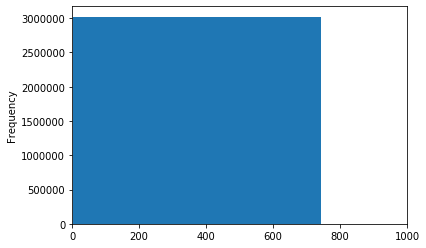

In [21]:
df_pd_users['event_time'].plot(kind='hist', xlim = (0,1000)) #not useful, previously(with no x-limit) got one bar in histogram 
#so plotted for 0-1000 range specifically, that is still not helpful

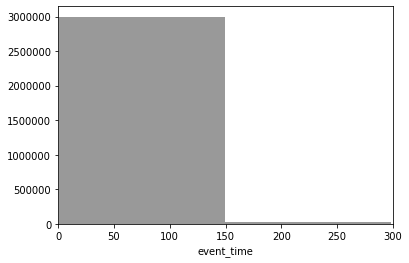

In [22]:
#changed the range again, looks like a exponential distribution, will check with other plots as well 
hist_plot = sns.distplot(df_pd_users['event_time'],kde=False, color = 'black')
hist_plot.set(xlim=(0, 300))

plt.show()

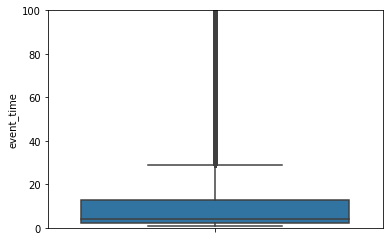

In [23]:
#Same results, box plot indicates the data is exponentially distributed
a_plot = sns.boxplot( y = df_pd_users['event_time'], data = df_pd_users)
a_plot.set(ylim=(0, 100))
plt.show()

Exponential distribution of number of visits of the users

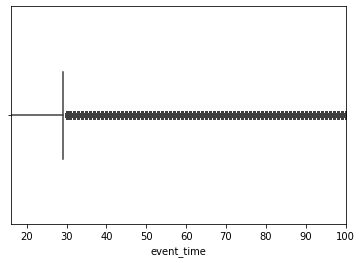

In [24]:
#check data for other  ranges as well
c_plot = sns.boxplot(df_pd_users['event_time'])
c_plot.set(xlim=(16, 100))

plt.show()

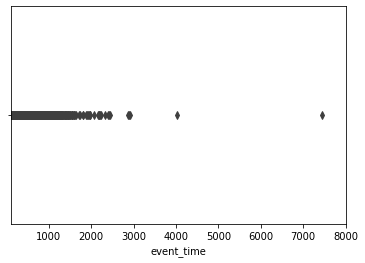

In [25]:
#check data for other ranges as well
c_plot = sns.boxplot(df_pd_users['event_time'])
c_plot.set(xlim=(100, 8000))

plt.show()

Looks like we have all the outliers beyond 30 till 2500 visits with 3 cutomers beyong 2500. Although, they are outlier users, we can form a different group for them without 3 extreme outlier users to specifically analyze those customers.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


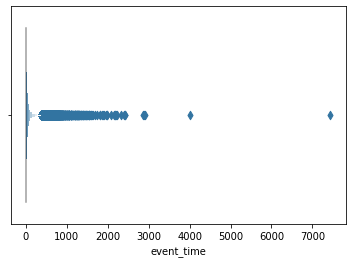

In [26]:
#boxen plots to check the distribution more specifically within ranges
sns.boxenplot(x='event_time', data=df_pd_users)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


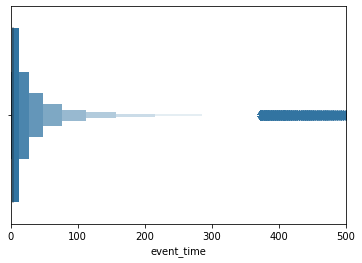

In [27]:
#boxen plot for a specific range that holds most of the users
d_plot = sns.boxenplot(x='event_time', data=df_pd_users)
d_plot.set(xlim=(0, 500))

plt.show()

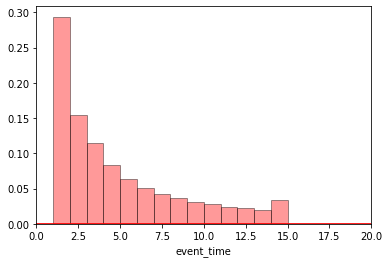

In [28]:
#to check the prbability density of the users based on their visits
kde_plot = sns.distplot(df_pd_users['event_time'], bins=np.arange(0,16),color = 'red', hist_kws=dict(ec="k")) #check its interpretation
kde_plot.set(xlim=(0, 20))

plt.show()

In [29]:
#check variance as it should have high variance being an exponenetial distribution
df_pd_users['event_time'].var()

1074.1423876104072

In [30]:
#Should be 3 users as per above boxplots/boxen plots, confirming the same, 
#these users should be removed as outliers values for analysis
df_pd_users[df_pd_users['event_time'] >2900]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_session
user_id,,,,,,,,
512365995,4013,4013,4013,4013,3986,4001,4013,4013
512475445,7436,7436,7436,7436,6703,6304,7436,7436
526731152,2912,2912,2912,2912,2148,2316,2912,2912


Majority of users have 15 or below visits and others falls in outlier range, which make sense as we have mean of ~14 visits and 75% users 13 or below visits, high variance of 1074

According to above statistics and graphs lets divide our users in 3 groups and analyze each group individually<br>
group-1(<=4, 50% users)<br>
group-2(>4 and <=15, ~25% users)<br>
group-3(>15) ~25% users<br>
so, will analyze group 3 as oulier group analysis

## Group-wise Data Cleaning & Analysis:

As per previous section, we will deal with outlier data and clean the required missing values and datatype conversions below in each group:

##### Group-1:

In [11]:
#get user ids of grp-1 users
users_grp1 = df_pd_users[df_pd_users['event_time'] <= 4].index

In [12]:
users_grp1.shape # ~50% of the users

(1519281,)

In [13]:
#get their user data from dask original dataframe
df_grp_1 = df[df['user_id'].isin(users_grp1)]

In [92]:
#convert to pandas dataframe for analysis
df_grp_pd_1 = pd.DataFrame(df_grp_1.compute())

In [93]:
df_grp_pd_1.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
6,2019-10-01 00:00:08 UTC,view,17300353,2053013553853497655,NaN,creed,380.96,555447699,4fe811e9-91de-46da-90c3-bbd87ed3a65d
7,2019-10-01 00:00:08 UTC,view,31500053,2053013558031024687,NaN,luminarc,41.16,550978835,6280d577-25c8-4147-99a7-abc6048498d6
8,2019-10-01 00:00:10 UTC,view,28719074,2053013565480109009,apparel.shoes.keds,baden,102.71,520571932,ac1cd4e5-a3ce-4224-a2d7-ff660a105880
10,2019-10-01 00:00:11 UTC,view,2900536,2053013554776244595,appliances.kitchen.microwave,elenberg,51.46,555158050,b5bdd0b3-4ca2-4c55-939e-9ce44bb50abd


In [94]:
df_grp_pd_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3006036 entries, 1 to 274871
Data columns (total 9 columns):
event_time       object
event_type       object
product_id       int64
category_id      int64
category_code    object
brand            object
price            float64
user_id          int64
user_session     object
dtypes: float64(1), int64(3), object(5)
memory usage: 229.3+ MB


In [95]:
df_grp_pd_1.isnull().sum()

event_time            0
event_type            0
product_id            0
category_id           0
category_code    982530
brand            385868
price                 0
user_id               0
user_session          0
dtype: int64

### We need to change datatype of event_time column and impute values for category_code and brand (to prevent data loss as an outcome of dropping).

In [98]:
#convert event_time to datetime object 
#df_grp_pd_1['event_time'] = pd.to_datetime(df_grp_pd_1['event_time'], format='%Y-%m-%d %H:%M:%S %Z', errors='coerce')

#we don't need event_time
df_grp_pd_1.drop(columns = ['event_time'], inplace = True)

In [99]:
df_grp_pd_1['brand'].fillna('No Brand', inplace = True)

In [100]:
df_grp_pd_1['category_code'].fillna('No category_code', inplace = True)

In [101]:
df_grp_pd_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3006036 entries, 1 to 274871
Data columns (total 8 columns):
event_type       object
product_id       int64
category_id      int64
category_code    object
brand            object
price            float64
user_id          int64
user_session     object
dtypes: float64(1), int64(3), object(4)
memory usage: 206.4+ MB


In [102]:
df_grp_pd_1.isnull().sum()

event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

In [103]:
df_grp_pd_1['event_type'].value_counts()

view        2942081
purchase      32217
cart          31738
Name: event_type, dtype: int64

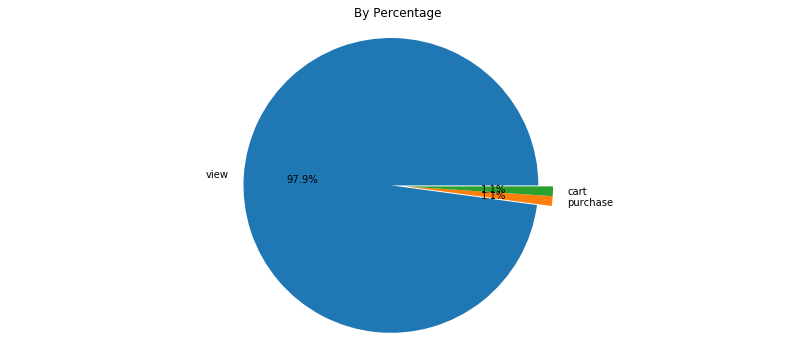

In [104]:
# pie-chart of users as per event-type distribution

labels= df_grp_pd_1['event_type'].value_counts().index.tolist()
sizes= df_grp_pd_1['event_type'].value_counts().values.tolist()     
explode=(0.1,0,0)
fig,ax=plt.subplots(1,1,figsize=(14,6))
ax.pie(sizes,labels=labels,explode=explode, autopct='%1.1f%%')
ax.set_title('By Percentage')
ax.axis('equal')
plt.show()

As expected most of the users just viewed the products. They can be recommended the products with maximum ratings and using product/user similarity(correlations) matrix as build in data modelling section later, they can be recommeded similar users viewed products or similar products to the one they viewed.

Let's see few users who purchased and added to cart, their jouney in user sessions

In [105]:
df_grp_pd_1[df_grp_pd_1['event_type'] == 'purchase']['user_id'][0:9]

2073    555168263
3604    555462614
3899    547560322
5142    519292368
5402    553819262
6496    555462711
7415    514651026
7632    514904277
9367    554063800
Name: user_id, dtype: int64

In [106]:
df_grp_pd_1[df_grp_pd_1['user_id'] == 555168263]

,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
1902,view,1004659,2053013555631882655,electronics.smartphone,samsung,787.18,555168263,d068d08f-aaf3-4949-b031-cdaf49a5c7cf
1960,cart,1004659,2053013555631882655,electronics.smartphone,samsung,787.18,555168263,d068d08f-aaf3-4949-b031-cdaf49a5c7cf
2073,purchase,1004659,2053013555631882655,electronics.smartphone,samsung,787.18,555168263,d068d08f-aaf3-4949-b031-cdaf49a5c7cf


In [107]:
df_grp_pd_1[df_grp_pd_1['user_id'] == 548742975]

,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
272543,view,1004767,2053013555631882655,electronics.smartphone,samsung,242.63,548742975,cd341dcb-1996-423d-b0a6-b1584888b079
272694,purchase,1004767,2053013555631882655,electronics.smartphone,samsung,242.63,548742975,cd341dcb-1996-423d-b0a6-b1584888b079
272961,view,1004767,2053013555631882655,electronics.smartphone,samsung,242.63,548742975,cd341dcb-1996-423d-b0a6-b1584888b079


In [108]:
df_grp_pd_1[df_grp_pd_1['user_id'] == 566270177]

,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
263569,view,22700129,2053013556168753601,No category_code,stels,75.94,566270177,337da7cd-c59e-42f4-b648-f83f3c5c268b
263728,purchase,22700129,2053013556168753601,No category_code,stels,75.94,566270177,337da7cd-c59e-42f4-b648-f83f3c5c268b
263807,view,22700129,2053013556168753601,No category_code,stels,75.94,566270177,337da7cd-c59e-42f4-b648-f83f3c5c268b


In [111]:
grp1_purchase_users = df_grp_pd_1[df_grp_pd_1['event_type'] == 'purchase']['user_id']

In [115]:
grp1_purchase_users = grp1_purchase_users.unique()

In [116]:
df_grp1_pur_users = df_grp_pd_1[df_grp_pd_1['user_id'].isin(grp1_purchase_users)]

In [117]:
df_grp1_pur_users['event_type'].value_counts()

view        62348
purchase    32217
cart        11870
Name: event_type, dtype: int64

So,looks like users that purchased, have atleast 3 events in a single user session which sounds logical. However, there is some data discepency due to less cart than purchases as event types. The reason behind it is, a user cannot purchase without adding product to the cart. Although, their are double views for such cases.

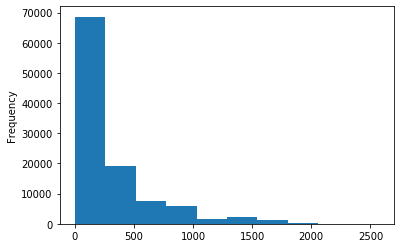

In [118]:
#check price range of this group
df_grp1_pur_users['price'].plot(kind = 'hist')

In [119]:
grp_1_top_pur_brands = df_grp1_pur_users['brand'].value_counts()[:20]

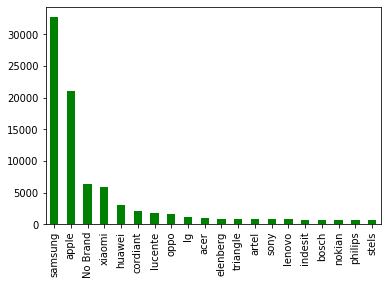

In [120]:
#group-1 top brands that are purchased
grp_1_top_pur_brands.plot(kind = 'bar', color = 'green')

In [121]:
grp_1_top_pur_products = df_grp1_pur_users['product_id'].value_counts()[:20]

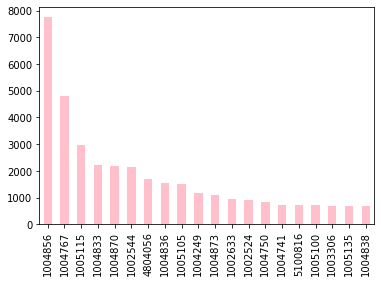

In [122]:
#group-1 top products that were purchased
grp_1_top_pur_products.plot(kind = 'bar', color = 'pink')

In [123]:
#check most viewed category
df_grp_pd_1[df_grp_pd_1['event_type'] != 'purchase']['category_code'].value_counts()[:20]

electronics.smartphone              1006181
No category_code                     975492
electronics.audio.headphone          100306
electronics.clocks                    93334
electronics.video.tv                  65048
appliances.kitchen.washer             53392
computers.notebook                    52056
appliances.kitchen.refrigerators      46669
appliances.environment.vacuum         38560
apparel.shoes                         36900
auto.accessories.player               26885
apparel.shoes.keds                    25275
electronics.tablet                    23532
furniture.bedroom.bed                 19940
computers.desktop                     17658
apparel.costume                       13244
furniture.living_room.sofa            13120
kids.toys                             12519
auto.accessories.videoregister        12370
kids.carriage                         12184
Name: category_code, dtype: int64

Mostly viewed and mostly purchased are electronic items(specifically smart phones and accessories). So, we can assume that increasing views might increase purchasing potential of a product.

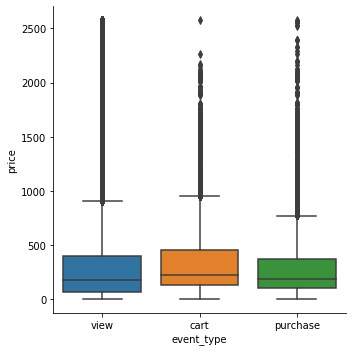

In [124]:
sns.catplot(x="event_type", y="price", kind="box", data=df_grp_pd_1)

So, looks like there are many outliers as per price, with 100-500 dollars range for all 3 event types(view, cart, purchase) i.e. to be more or less in the same price range. Thats makes sense as per views and purchases positive correlation as we assumed by interpreting previous plots.

#### Group-2

In [71]:
#get user ids of grp-2 users
users_grp2 = df_pd_users[(df_pd_users['event_time'] > 4) & (df_pd_users['event_time'] <=15)].index

In [72]:
users_grp2.shape # ~25% of the users

(834330,)

In [74]:
#get their user data from dask original dataframe
df_grp_2 = df[df['user_id'].isin(users_grp2)]

In [ ]:
#convert to pandas dataframe for analysis
df_grp_pd_2 = pd.DataFrame(df_grp_2.compute())

In [76]:
df_grp_pd_2.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
9,2019-10-01 00:00:11 UTC,view,1004545,2053013555631882655,electronics.smartphone,huawei,566.01,537918940,406c46ed-90a4-4787-a43b-59a410c1a5fb
14,2019-10-01 00:00:16 UTC,view,13500240,2053013557099889147,furniture.bedroom.bed,brw,93.18,555446365,7f0062d8-ead0-4e0a-96f6-43a0b79a2fc4
17,2019-10-01 00:00:18 UTC,view,10900029,2053013555069845885,appliances.kitchen.mixer,bosch,58.95,519528062,901b9e3c-3f8f-4147-a442-c25d5c5ed332
20,2019-10-01 00:00:20 UTC,view,1003306,2053013555631882655,electronics.smartphone,apple,588.77,555446831,6ec635da-ea15-4a5d-96b4-c8ca9d38f89f
21,2019-10-01 00:00:20 UTC,view,4803399,2053013554658804075,electronics.audio.headphone,jbl,33.21,555428858,8a6afed4-77f8-40c9-8e76-e062b28216ce


In [77]:
df_grp_pd_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7227657 entries, 9 to 274862
Data columns (total 9 columns):
event_time       object
event_type       object
product_id       int64
category_id      int64
category_code    object
brand            object
price            float64
user_id          int64
user_session     object
dtypes: float64(1), int64(3), object(5)
memory usage: 551.4+ MB


In [78]:
df_grp_pd_2.isnull().sum()

event_time             0
event_type             0
product_id             0
category_id            0
category_code    2235814
brand             937989
price                  0
user_id                0
user_session           2
dtype: int64

In [81]:
#we don't need event_time
df_grp_pd_2.drop(columns = ['event_time'], inplace = True)

In [83]:
#handling missing values
df_grp_pd_2['brand'].fillna('No Brand', inplace = True)
df_grp_pd_2['category_code'].fillna('No category_code', inplace = True)

In [85]:
remove_sessions = df_grp_pd_2[df_grp_pd_2['user_session'].isnull()].index
df_grp_pd_2.drop(remove_sessions, inplace = True)

In [86]:
df_grp_pd_2.isnull().sum()

event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

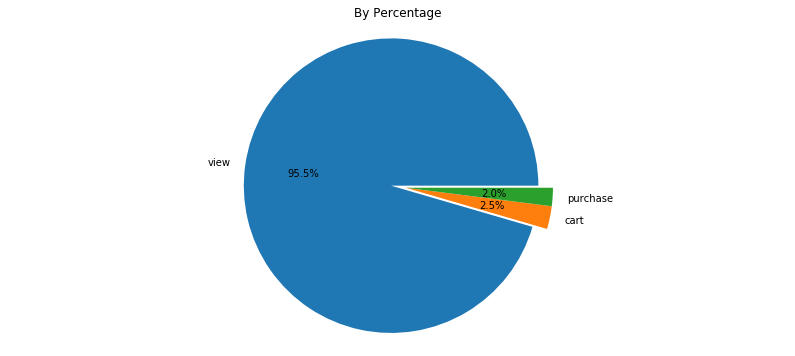

In [87]:
# pie-chart of users as per event-type distribution

labels= df_grp_pd_2['event_type'].value_counts().index.tolist()
sizes= df_grp_pd_2['event_type'].value_counts().values.tolist()     
explode=(0.1,0,0)
fig,ax=plt.subplots(1,1,figsize=(14,6))
ax.pie(sizes,labels=labels,explode=explode, autopct='%1.1f%%')
ax.set_title('By Percentage')
ax.axis('equal')
plt.show()

In [125]:
#grp-2 users who purchased
grp2_purchase_users = df_grp_pd_2[df_grp_pd_2['event_type'] == 'purchase']['user_id']
grp2_purchase_users = grp2_purchase_users.unique()
df_grp2_pur_users = df_grp_pd_2[df_grp_pd_2['user_id'].isin(grp2_purchase_users)]

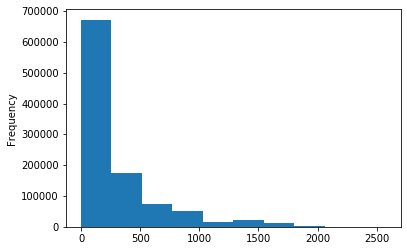

In [126]:
#check price range of this group
df_grp2_pur_users['price'].plot(kind = 'hist')

In [127]:
grp_2_top_pur_brands = df_grp2_pur_users['brand'].value_counts()[:20]

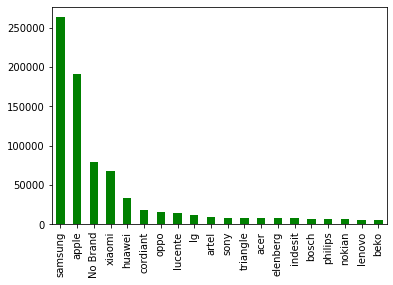

In [128]:
#group-2 top brands that are purchased
grp_2_top_pur_brands.plot(kind = 'bar', color = 'green')

In [129]:
grp_2_top_pur_products = df_grp2_pur_users['product_id'].value_counts()[:20]

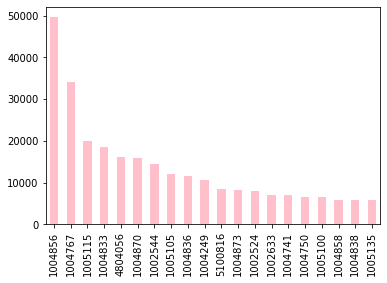

In [130]:
grp_2_top_pur_products.plot(kind = 'bar', color = 'pink')

In [131]:
#check most viewed category
df_grp_pd_2[df_grp_pd_2['event_type'] != 'purchase']['category_code'].value_counts()[:20]

electronics.smartphone              2209912
No category_code                    2205213
electronics.audio.headphone          207483
electronics.clocks                   202964
electronics.video.tv                 195796
computers.notebook                   152483
appliances.kitchen.washer            147704
appliances.kitchen.refrigerators     147386
appliances.environment.vacuum        123385
apparel.shoes                        109737
auto.accessories.player               76788
apparel.shoes.keds                    68333
furniture.bedroom.bed                 61010
computers.desktop                     54286
electronics.tablet                    53468
electronics.audio.subwoofer           40285
furniture.living_room.sofa            36365
furniture.living_room.cabinet         35973
electronics.telephone                 35696
auto.accessories.videoregister        35196
Name: category_code, dtype: int64

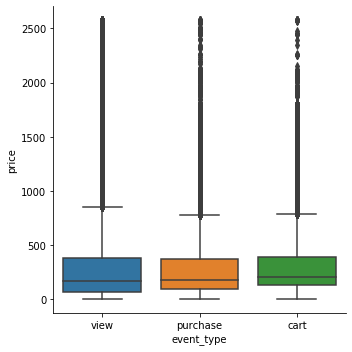

In [133]:
sns.catplot(x="event_type", y="price", kind="box", data=df_grp_pd_2)

#### Outliers Group:

In [6]:
#get user ids of grp-2 users
users_grp3 = df_pd_users[(df_pd_users['event_time'] > 15)].index

In [136]:
users_grp3.shape # ~22% of the users

(668679,)

In [137]:
#get their user data from dask original dataframe
df_grp_3 = df[df['user_id'].isin(users_grp3)]

In [140]:
#convert to pandas dataframe for analysis
df_grp_pd_3 = pd.DataFrame(df_grp_3.compute())

In [141]:
df_grp_pd_3.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d
5,2019-10-01 00:00:05 UTC,view,1480613,2053013561092866779,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9


In [142]:
df_grp_pd_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32215071 entries, 0 to 274873
Data columns (total 9 columns):
event_time       object
event_type       object
product_id       int64
category_id      int64
category_code    object
brand            object
price            float64
user_id          int64
user_session     object
dtypes: float64(1), int64(3), object(5)
memory usage: 2.4+ GB


In [143]:
df_grp_pd_3.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d
5,2019-10-01 00:00:05 UTC,view,1480613,2053013561092866779,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9


In [144]:
df_grp_pd_3.isnull().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    10297265
brand             4793223
price                   0
user_id                 0
user_session            0
dtype: int64

In [145]:
df_grp_pd_3.drop(columns = ['event_time'], inplace = True)

In [146]:
#handling missing values
df_grp_pd_3['brand'].fillna('No Brand', inplace = True)
df_grp_pd_3['category_code'].fillna('No category_code', inplace = True)

In [147]:
df_grp_pd_3.isnull().sum()

event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

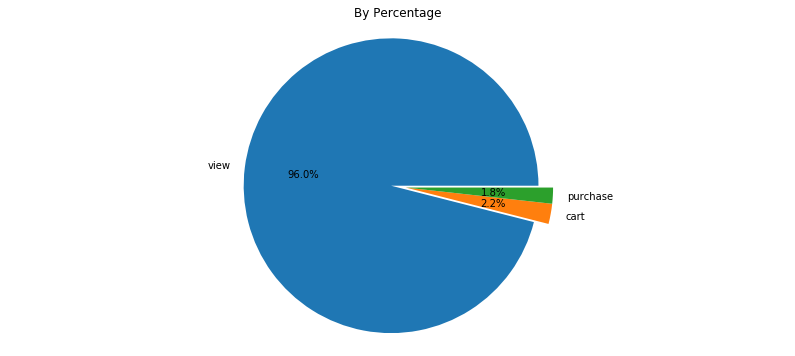

In [148]:
# pie-chart of users as per event-type distribution

labels= df_grp_pd_3['event_type'].value_counts().index.tolist()
sizes= df_grp_pd_3['event_type'].value_counts().values.tolist()     
explode=(0.1,0,0)
fig,ax=plt.subplots(1,1,figsize=(14,6))
ax.pie(sizes,labels=labels,explode=explode, autopct='%1.1f%%')
ax.set_title('By Percentage')
ax.axis('equal')
plt.show()

In [149]:
#grp-3 users who purchased
grp3_purchase_users = df_grp_pd_3[df_grp_pd_3['event_type'] == 'purchase']['user_id']
grp3_purchase_users = grp3_purchase_users.unique()
df_grp3_pur_users = df_grp_pd_3[df_grp_pd_3['user_id'].isin(grp3_purchase_users)]

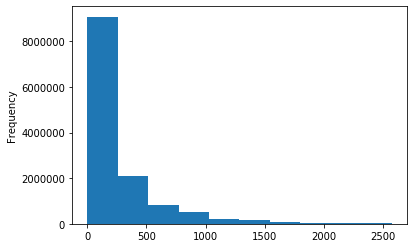

In [150]:
#check price range of this group
df_grp3_pur_users['price'].plot(kind = 'hist')

In [151]:
grp_3_top_pur_brands = df_grp3_pur_users['brand'].value_counts()[:20]

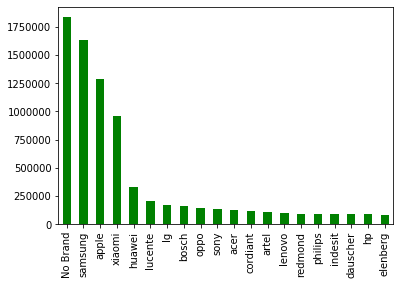

In [153]:
grp_3_top_pur_brands.plot(kind = 'bar', color = 'green')

In [154]:
grp_3_top_pur_products = df_grp3_pur_users['product_id'].value_counts()[:20]

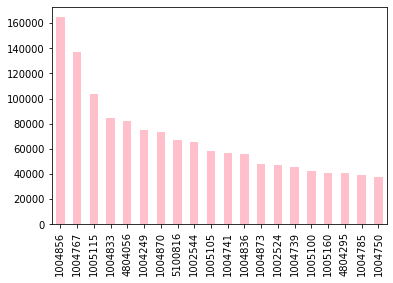

In [155]:
grp_3_top_pur_products.plot(kind = 'bar', color = 'pink')

In [156]:
#check most viewed category
df_grp_pd_3[df_grp_pd_3['event_type'] != 'purchase']['category_code'].value_counts()[:20]

No category_code                    10161472
electronics.smartphone               7953111
electronics.clocks                    996828
computers.notebook                    917493
electronics.video.tv                  831337
electronics.audio.headphone           761896
appliances.kitchen.refrigerators      682482
appliances.kitchen.washer             652159
appliances.environment.vacuum         627346
apparel.shoes                         613008
auto.accessories.player               361888
computers.desktop                     349066
apparel.shoes.keds                    313985
furniture.bedroom.bed                 275337
electronics.audio.subwoofer           258283
furniture.living_room.cabinet         253968
construction.tools.drill              236913
electronics.tablet                    234132
electronics.telephone                 196171
auto.accessories.videoregister        174135
Name: category_code, dtype: int64

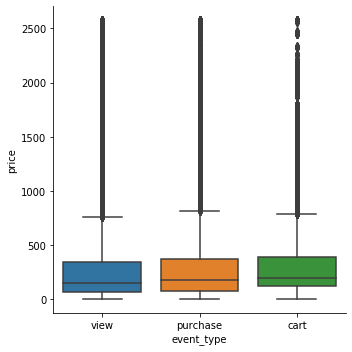

In [158]:
sns.catplot(x="event_type", y="price", kind="box", data=df_grp_pd_3)

All the groups have more or less the same trends for all the plots. Although not expected it.

### Data Modelling:

In [7]:
df_pd_users.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_session
user_id,,,,,,,,
244951053,15,15,15,15,15,12,15,15
306441847,9,9,9,9,9,9,9,9
321655812,16,16,16,16,16,13,16,16
330585300,6,6,6,6,6,6,6,6
332550649,7,7,7,7,1,4,7,7


In [8]:
new_df = df[~(df['user_id'].isin(users_grp3))]

In [9]:
new_pd_df = pd.DataFrame(new_df.compute())

In [10]:
new_pd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10233693 entries, 1 to 274871
Data columns (total 9 columns):
event_time       object
event_type       object
product_id       int64
category_id      int64
category_code    object
brand            object
price            float64
user_id          int64
user_session     object
dtypes: float64(1), int64(3), object(5)
memory usage: 780.8+ MB


In [20]:
new_pd_df.isnull().sum()

event_time             0
event_type             0
product_id             0
category_id            0
category_code    3218344
brand            1323857
price                  0
user_id                0
user_session           2
dtype: int64

In [11]:
new_pd_df.drop(columns = ['event_time'], inplace = True)

In [12]:
new_pd_df['brand'].fillna('No Brand', inplace = True)
new_pd_df['category_code'].fillna('No category_code', inplace = True)

In [13]:
idx_drps = new_pd_df[new_pd_df['user_session'].isnull()].index
new_pd_df.drop(idx_drps, inplace = True)

In [14]:
new_pd_df.isnull().sum()

event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

So, we have cleaned the data by handling missing values, removing unwanted columns and outlier data.

#### Using Purchase History For Recommendations

In [15]:
#check how many products bought at max by one user in october
new_pd_df_purchase = new_pd_df[new_pd_df['event_type'] == 'purchase']

In [16]:
len(new_pd_df_purchase)

177113

In [17]:
new_pd_df_purchase['event_type'].value_counts()

purchase    177113
Name: event_type, dtype: int64

In [18]:
purchase_user_grps_freq_products = new_pd_df_purchase.groupby('user_id').count()

In [19]:
len(purchase_user_grps_freq_products)

141037

In [20]:
#no of products bought with number of users
purchase_user_grps_freq_products['user_session'].value_counts()

1    112289
2     22633
3      5032
4       957
5       122
6         4
Name: user_session, dtype: int64

In [21]:
#users id with 6 or more products
users_4_more_products = purchase_user_grps_freq_products[purchase_user_grps_freq_products['user_session'] >= 4].index.tolist()
#user ids of less than 4 and 5 products
users_3_products = purchase_user_grps_freq_products[(purchase_user_grps_freq_products['user_session'] == 3) | (purchase_user_grps_freq_products['user_session'] == 5)].index.tolist()
#user ids of less than 2,3 products
users_2_less_products = purchase_user_grps_freq_products[(purchase_user_grps_freq_products['user_session'] == 2) | (purchase_user_grps_freq_products['user_session'] == 3)].index.tolist()
#user ids of 1 products
users_1_products = purchase_user_grps_freq_products[purchase_user_grps_freq_products['user_session'] == 1].index.tolist()

In [22]:
print(len(users_4_more_products))
print(len(users_3_products))
print(len(users_2_less_products))
print(len(users_1_products))

1083
5154
27665
112289


In [23]:
middle_index = len(users_1_products)//2
first_half_1_product = users_1_products[:middle_index]
second_half_1_product = users_1_products[middle_index:]

In [24]:
new_pd_df['ratings'] = np.zeros(len(new_pd_df), dtype=int)

In [25]:
new_pd_df['ratings'] = np.where(new_pd_df['user_id'].isin(users_4_more_products), 
                           5,      
                           new_pd_df['ratings'])     
new_pd_df['ratings'] = np.where(new_pd_df['user_id'].isin(users_3_products), 
                           4,      
                           new_pd_df['ratings'])     
new_pd_df['ratings'] = np.where(new_pd_df['user_id'].isin(users_2_less_products), 
                           3,      
                           new_pd_df['ratings'])     
new_pd_df['ratings'] = np.where(new_pd_df['user_id'].isin(first_half_1_product), 
                           2,      
                           new_pd_df['ratings'])     
new_pd_df['ratings'] = np.where(new_pd_df['user_id'].isin(second_half_1_product), 
                           1,      
                           new_pd_df['ratings'])     

In [26]:
new_pd_df['ratings'].value_counts()

0    9102415
2     440762
1     387290
3     288741
5      12720
4       1724
Name: ratings, dtype: int64

As most of the data is view or carts so rating only for products that were purchased. 

In [27]:
grp_usr = new_pd_df.groupby('user_id').count()

In [28]:
grp_usr.shape

(2353608, 8)

In [29]:
new_pd_df.shape

(10233652, 9)

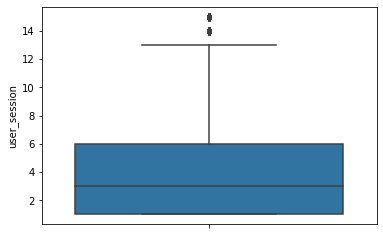

In [30]:
#check data distribution again
a_plot = sns.boxplot(y = grp_usr['user_session'], data = grp_usr)
plt.show()

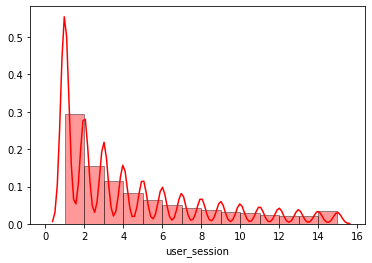

In [42]:
#to check the prbability density of the users based on their visits
kde_plot = sns.distplot(grp_usr['user_session'], bins=np.arange(0,16),color = 'red', hist_kws=dict(ec="k")) #check its interpretation
#kde_plot.set(xlim=(0, 20))
plt.show()

As we can see, now data has very less outliers. The number of visits have left-skewed normal data distribution. 

In [31]:
#users between 1 and 10
user_1_10 = grp_usr[(grp_usr['user_session']>1) & (grp_usr['user_session']<10)].index.tolist()

In [32]:
print(len(user_1_10))

1359341


In [33]:
user_det_1_10 = new_pd_df[(new_pd_df['user_id'].isin(user_1_10))]

In [34]:
user_det_1_10.shape

(5849383, 9)

In [35]:
user_det_1_10['event_type'].value_counts()

view        5630620
cart         116438
purchase     102325
Name: event_type, dtype: int64

In [36]:
user_det_1_10['ratings'].value_counts()

0    5339028
1     222558
2     206408
3      81138
5        251
Name: ratings, dtype: int64

In [37]:
#k-means data preparations-

In [38]:
new_pd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10233652 entries, 1 to 274871
Data columns (total 9 columns):
event_type       object
product_id       int64
category_id      int64
category_code    object
brand            object
price            float64
user_id          int64
user_session     object
ratings          int32
dtypes: float64(1), int32(1), int64(3), object(4)
memory usage: 741.7+ MB


In [93]:
df_final = new_pd_df[new_pd_df['category_code'] != 'No category_code']

In [94]:
#relevant properties to categories users
df_final = df_final[['event_type','price','ratings']]

In [95]:
df_final.shape

(7015318, 3)

In [96]:
#user_det_1_10_cluster['category_code'] = user_det_1_10_cluster['category_id'].astype('category')

Had to remove category code from the features as K-means crashed with 117 categories features. Though we can use it to prepare clusters of customers with scalable resources.

In [97]:
#one-hot encoding
df_final = pd.get_dummies(df_final, drop_first=True)

In [98]:
df_final.shape

(7015318, 4)

In [99]:
X_train, X_test= train_test_split(df_final.values, 
                                test_size=0.3, 
                                random_state=1) 

In [100]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

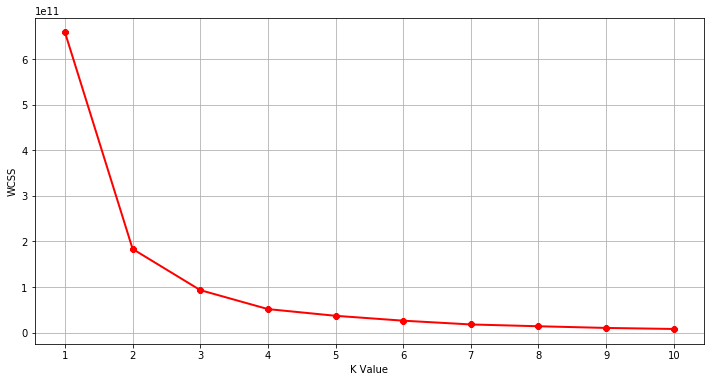

In [90]:
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(df_final.iloc[:,:])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

So, as assumed, 3 clusters/user groups will be optimal for our customers as per elbow method(based on variation explained criteria by the number of clusters.)

In [101]:
#K-means clustering and attaching label(cluster-label) to the data
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(X_train)

clusters_train = kmeans.predict(X_train)
clusters_test = kmeans.predict(X_test)

In [102]:
#check compositions of clusters(counts)
np.unique(clusters_train)

array([0, 1, 2])

In [103]:
np.unique(clusters_test)

array([0, 1, 2])

In [104]:
print(np.count_nonzero(clusters_train == 0))
print(np.count_nonzero(clusters_train == 1))
print(np.count_nonzero(clusters_train == 2))

271949
3699472
939301


In [105]:
print(np.count_nonzero(clusters_test == 0))
print(np.count_nonzero(clusters_test == 1))
print(np.count_nonzero(clusters_test == 2))

116500
1585973
402123


Composition of clusters in both groups looks similar.

In [51]:
#to check dataframe specific cluster labels and properties

In [106]:
label = kmeans.predict(df_final)
print(label)

[1 1 2 ... 1 1 1]


In [107]:
print(np.count_nonzero(label == 0))
print(np.count_nonzero(label == 1))
print(np.count_nonzero(label == 2))

388449
5285445
1341424


In [108]:
filtered_label0 = df_final[label == 0]
filtered_label1 = df_final[label == 1]
filtered_label2 = df_final[label == 2]

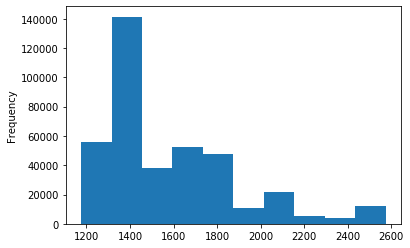

In [110]:
filtered_label0['price'].plot(kind = 'hist')

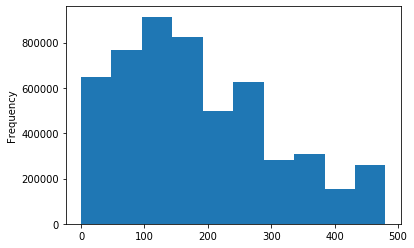

In [111]:
filtered_label1['price'].plot(kind = 'hist')

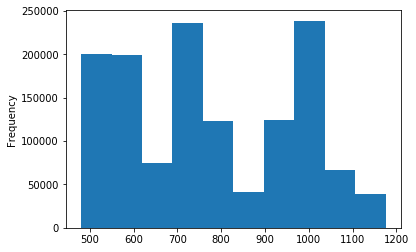

In [112]:
filtered_label2['price'].plot(kind = 'hist')

In [113]:
filtered_label0['ratings'].value_counts()

0    345471
2     17794
3     12857
1     11636
5       620
4        71
Name: ratings, dtype: int64

In [ ]:
sns.catplot(x="day", y="total_bill", data=tips)

In [114]:
filtered_label1['ratings'].value_counts()

0    4614330
2     247338
1     241895
3     173348
5       7553
4        981
Name: ratings, dtype: int64

In [115]:
filtered_label2['ratings'].value_counts()

0    1187663
2      58569
1      47382
3      45421
5       2148
4        241
Name: ratings, dtype: int64

So, according to event types, product prices and ratings users got clustered in 3 groups. Further, product recommendations can be made to the same group users. Also, category of products have given better featured clustered. But due to scaliblity issue, it can be considered in scope for this model in future.

Also, all the clustered have majority of view/cart users. We can use purchase history users of each group with the ratings to further target users(view/cart category). 

Further, below are some modelling techniques(Association rules(Apriori algo) and correlation matrix(Trucated(SVD) algo)) that can be applied in each cluster to find product utility similarity and user similarity to recommend products in future.

#### Association rules :

We will use purchase history of users below and find associated products.<br>
In future scope, similar technique can be applied to top viewed products as well.

In [118]:
new_pd_df_purchase['product_id'].value_counts()[2:20]

1005115    3833
1004833    3657
4804056    3306
1004870    3306
1002544    3154
1004836    2356
1005105    2244
1004249    1988
1004873    1688
1002524    1633
5100816    1588
1002633    1506
1004750    1317
1004741    1311
1005100    1218
1004838    1133
1004858    1123
1003306    1113
Name: product_id, dtype: int64

Let's study top 18 products to find frequent itemsets as products and users

In [121]:
products = new_pd_df_purchase['product_id'].value_counts()[2:20].index.tolist()

In [122]:
products

[1005115,
 1004833,
 4804056,
 1004870,
 1002544,
 1004836,
 1005105,
 1004249,
 1004873,
 1002524,
 5100816,
 1002633,
 1004750,
 1004741,
 1005100,
 1004838,
 1004858,
 1003306]

In [123]:
products_df = new_pd_df[(new_pd_df['product_id'].isin(products)) & (new_pd_df['event_type'] == 'purchase')]

In [124]:
products_df = products_df[['product_id','user_id','ratings']]

In [125]:
products_df.drop_duplicates(keep=False,inplace=True)

In [126]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30281 entries, 618 to 274767
Data columns (total 3 columns):
product_id    30281 non-null int64
user_id       30281 non-null int64
ratings       30281 non-null int32
dtypes: int32(1), int64(2)
memory usage: 828.0 KB


In [127]:
products_df['user_id'].nunique()

28940

In [276]:
products_df.head()

,product_id,user_id,ratings
379,5100816,514591159,2
618,1002524,524325294,3
2973,1004870,513265392,2
3574,5100816,549614436,3
4541,1004741,552439521,1


In [128]:
usr_prod_grps = products_df.groupby('user_id')

In [135]:
usr_prod_grps.get_group(514373780)

,product_id,user_id,ratings
476182,1005105,514373780,3
477733,1005115,514373780,3
170343,1002524,514373780,3


Recommend all the top products and linked products as above to all other users in the group.

In [139]:
user_tab = pd.crosstab(index=products_df['user_id'], columns=products_df['product_id'])

In [140]:
user_tab.shape

(28940, 18)

In [142]:
user_tab.head()

product_id,1002524,1002544,1002633,1003306,1004249,1004741,1004750,1004833,1004836,1004838,1004858,1004870,1004873,1005100,1005105,1005115,4804056,5100816
user_id,,,,,,,,,,,,,,,,,,
403013066,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
431246706,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
438992161,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
441522689,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
444316141,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [143]:
freq_products_items = apriori(user_tab, min_support=0.001, use_colnames=True, verbose=1)
freq_products_items.head(7)

Processing 93 combinations | Sampling itemset size 3


,support,itemsets
0,0.044990,(1002524)
1,0.087941,(1002544)
2,0.042260,(1002633)
3,0.031548,(1003306)
4,0.055943,(1004249)
5,0.037526,(1004741)
6,0.036973,(1004750)


In [147]:
rules = association_rules(freq_products_items, metric="confidence", min_threshold=0.01)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1002544),(1002524),0.087941,0.044990,0.001624,0.018468,0.410485,-0.002332,0.972979
1,(1002524),(1002544),0.044990,0.087941,0.001624,0.036098,0.410485,-0.002332,0.946216
2,(1002544),(1002633),0.087941,0.042260,0.001589,0.018075,0.427703,-0.002127,0.975370
3,(1002633),(1002544),0.042260,0.087941,0.001589,0.037612,0.427703,-0.002127,0.947705
4,(1002544),(1003306),0.087941,0.031548,0.001486,0.016896,0.535560,-0.001289,0.985096


We got very low association's support, confidence and lift values. Unsignificant associations. Need more purchase history to improve thes metrics to dive the associations.
Also, we can use these association rules to find associated users(future scope).

#### Coorelation Matrix to find correlated products based on products utility(ratings):

In [154]:
#sliced top purchased products
df_user_product_max = products_df.groupby('user_id').count()

In [152]:
df_user_product_max[df_user_product_max['product_id'] == 3].head()

,product_id,ratings
user_id,,
513716260,3,3
514146547,3,3
514322393,3,3
514373780,3,3
514528187,3,3


In [153]:
user_ratings_tab = products_df.pivot_table(values='ratings', index='user_id', columns='product_id', fill_value=0)
user_ratings_tab.head()

product_id,1002524,1002544,1002633,1003306,1004249,1004741,1004750,1004833,1004836,1004838,1004858,1004870,1004873,1005100,1005105,1005115,4804056,5100816
user_id,,,,,,,,,,,,,,,,,,
403013066,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0
431246706,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
438992161,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
441522689,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
444316141,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [155]:
#to get product specific ratings values for each user
user_ratings_tab_t = user_ratings_tab.T

In [156]:
user_ratings_tab_t.shape

(18, 28940)

In [157]:
#for matrix decomposition(ratings pivot table) into 10 components
svd = TruncatedSVD(n_components=10)
decomposed_matrix = svd.fit_transform(user_ratings_tab_t)
decomposed_matrix.shape

(18, 10)

In [158]:
#find the correlation of products based on ratings, decomposed matrix
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(18, 18)

In [159]:
#product - 1004741
pro_ids = user_ratings_tab_t.index.tolist()
pro_id = pro_ids.index(1004741)

In [160]:
corr_pr_id = correlation_matrix[pro_id]

In [161]:
corr_pr_id

array([ 0.77922766,  0.10328359,  0.86598608,  0.1458219 , -0.19913924,
        1.        ,  0.08314894,  0.13276705, -0.36218311,  0.58061297,
        0.4191996 ,  0.03950839,  0.21516992,  0.13652748, -0.4222156 ,
       -0.12580917, -0.35565095,  0.04417995])

In [162]:
#correlated products recommendations as per ratings
corr_pr_id[corr_pr_id > 0.60]

array([0.77922766, 0.86598608, 1.        ])

In [163]:
recommend_products = user_ratings_tab_t.index[corr_pr_id > 0.60].tolist()
recommend_products[1:]

[1002633, 1004741]

So, all users who bought 1004741 product will be recommended 1002633 and 1004741 products as well.